In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
device_id = 1
device_name = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(device_name)
print('Using {} device'.format(DEVICE))

Using cuda:1 device


In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(2)

In [4]:
class Drift(nn.Module):
    def __init__(self, input_dim):
        super(Drift, self).__init__()
        self.embedder = torch.nn.Sequential(
            torch.nn.Linear(input_dim+1, 2000),
            torch.nn.ReLU(),
            torch.nn.Linear(2000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, input_dim)
        )
    
    def forward(self, x_t, t):
        if isinstance(t, (int, float)):
            n = x_t.size(0)
            T = t*torch.ones((n, 1)).float().to(DEVICE)
            X = torch.cat((x_t, T), dim=1)
        elif isinstance(t, torch.Tensor):
            X = torch.cat((x_t, t), dim=1)
        return self.embedder(X)

class drift_gaussian_gaussian(nn.Module):
    def __init__(self, mu0, mu1, sigma2_0, sigma2_1):
        super(drift_gaussian_gaussian, self).__init__()
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma2_0 = sigma2_0
        self.sigma2_1 = sigma2_1

    def score(self, x_t, t):
        sigma2_t = self.sigma2_1*t*t + self.sigma2_0*(1-t)*(1-t)
        mu_t = self.mu1*t + self.mu0*(1-t)
        s_t = (t*mu_t - x_t)/sigma2_t

        return s_t
    
    def forward(self, x_t, t):
        if t==1.0:
            return x_t - self.mu0
        elif t==0.0:
            return self.mu1 - x_t
        else:
            v_t = x_t/t + ((1-t)/t)*self.score(x_t, t)
            return v_t
        
class CustomDataset(Dataset):
    def __init__(self, X, Z):
        self.X = X
        self.Z = Z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Z[idx]

In [5]:
# Training loop

def train(model, num_epochs, dataloader, save_loss):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch in dataloader:
            x, z = batch
            m, d = z.size(0), z.size(1)

            # perm = torch.randperm(m)
            # x = x[perm, :].to(DEVICE).float()
            # z = z[perm, :].to(DEVICE).float()
            
            x = x.to(DEVICE).float()
            z = z.to(DEVICE).float() 

            x = x.unsqueeze(0).repeat(m, 1, 1).reshape(-1, d)
            z = z.unsqueeze(1).repeat(1, m, 1).reshape(-1, d)

            t = torch.from_numpy(np.random.uniform(0, 1, z.size(0))).to(DEVICE).float().view(-1, 1)
            x_t = t*x + (1-t)*z

            # Zero the parameter gradients
            model_optimizer.zero_grad()

            # Compute loss
            loss = criterion(model(x_t, t), (x-z))

            # Backward pass and optimize
            loss.backward()
            model_optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate and print average loss for the epoch
        avg_loss = epoch_loss / num_batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Step the scheduler with the average loss
        scheduler.step(avg_loss)

        save_loss.append(avg_loss)
    
    return save_loss


def plot_loss(save_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(save_loss, marker='o', linestyle='-', color='b')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    plt.close()
    return

In [6]:
import numpy as np

def assign_labels_to_points(points_array):
    """
    Vectorized function to assign color labels to an array of points.
    
    Arguments:
    points_array -- NumPy array of shape (n, 2) representing n points with x and y coordinates.
    
    Returns:
    labels_array -- NumPy array of shape (n,) containing the labels for each point.
    """
    x_points = points_array[:, 0]  # Extract x coordinates
    y_points = points_array[:, 1]  # Extract y coordinates
    
    # Initialize labels to -1 (for points outside the black boxes)
    labels = np.full(points_array.shape[0], 20)
    color_idx = -1
    # Iterate over black box grid boundaries
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (i + j) % 2 == 0:  # Condition for black boxes
                # Create boolean masks for points inside the current black box
                inside_x = (x_points >= i) & (x_points < i + 1)
                inside_y = (y_points >= j) & (y_points < j + 1)
                inside_box = inside_x & inside_y

                # Calculate color index based on the box's location
                color_idx = color_idx+2
                # Assign the color index to the points inside this black box
                labels[inside_box] = color_idx

    return labels

# # Example usage
# points_array = np.array([[0.5, -1.5], [-1.5, 0.5], [2.5, 2.5]])  # Example points
# labels_array = assign_labels_to_points(points_array)
# print(f"Labels for input points: {labels_array}")


In [7]:
def sample(model, T, num_samples, input_dim):
    Z_0_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

    Z_0 = torch.from_numpy(Z_0_np).to(DEVICE).float()

    with torch.no_grad():
        trajectory = Z_0.unsqueeze(0).repeat(T+1, 1, 1)
        ones = torch.ones((num_samples, 1)).float().to(DEVICE)
        drift_save = model(trajectory[0, :, :], 0*ones).repeat(T+1, 1, 1)

        for i in range(1, T+1):
            t_i_minus_1 = ones*(i-1)/T
            trajectory[i, :, :] = trajectory[i-1, :, :] + model(trajectory[i-1, :, :], t_i_minus_1)/T
            drift_save[i, :, :] = model(trajectory[i-1, :, :], t_i_minus_1)
    return trajectory, drift_save

def plot_trajectories(trajectory, plot_paths=True, plot_true=True):
    trajectory_np = trajectory.cpu().numpy()
    (T, n, d) = trajectory.shape
    color = assign_labels_to_points(trajectory_np[-1, :, :])
    if plot_paths:
        for i in range(n):
            particle_trajectory = trajectory_np[:, i, :]
            plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1, color=color[i])
            
    plt.scatter(trajectory_np[T-1, :, 0], trajectory_np[T-1, :, 1], label="End points", c=color)
    # plt.scatter(trajectory_np[0, :, 0], trajectory_np[0, :, 1], label="Initial points", color="orange")
    if plot_true: plt.scatter(X_np[:, 0], X_np[:, 1], label="Original data points", color="blue", alpha=0.05)
    
    plt.title('Trajectories of particles over time, T={}'.format(T-1))
    plt.legend()
    plt.show()
    plt.close()
    return

In [22]:
def jacobian(y, x):
    """ Compute the Jacobian of y with respect to x """
    jac = []
    for i in range(y.shape[1]):  # Iterate over the output dimensions
        grad_y = torch.zeros_like(y)
        grad_y[:, i] = 1  # One-hot vector for the i-th output component
        jac_i = torch.autograd.grad(y, x, grad_outputs=grad_y, retain_graph=True, create_graph=False)[0]
        jac.append(jac_i)
    return torch.stack(jac, dim=-1)  # Stack along the last dimension

def compute_total_derivative_vectorized(model, x_t, t):
    model.eval()
    # Enable gradients for t and x_t
    x_t = x_t.requires_grad_(True)
    t = t.requires_grad_(True)
    N, d = x_t.shape
    # Compute v(x_t, t)
    v_value = model(x_t, t)  # Shape: [batch_size, 2]
    
    # Compute partial derivative w.r.t. t (treating x_t as constant)
    v_t = []
    for i in range(v_value.shape[1]):  # Iterate over the output dimensions of v
        grad_outputs = torch.zeros_like(v_value)
        grad_outputs[:, i] = 1
        v_t_i = torch.autograd.grad(v_value[:, i], t, grad_outputs=grad_outputs[:, i], retain_graph=True)[0]
        v_t.append(v_t_i)
    
    v_t = torch.stack(v_t, dim=1).reshape(N, d)  # Shape: [batch_size, 2]
    
    # Compute Jacobian w.r.t. x_t (should be of shape [batch_size, 2, 2])
    v_x = jacobian(v_value, x_t)  # Shape: [batch_size, 2, 2]

    # print(v_value.shape, v_t.shape, v_x.shape)
    # Compute total derivative: dv/dt = dv/dt + (dv/dx_t) * (dx_t/dt)
    # Multiply the Jacobian by v_value, keeping the dimensions aligned
    total_derivative = v_t + torch.einsum('bij,bi->bj', v_x, v_value)  # Shape: [batch_size, 2]

    return total_derivative

def d_model_dt_norm_sq(model, trajectory, device):

    """
    Returns:
        expected_norm_squared_vector: A vector of the expected norm squared of the full derivative at each time step (shape: [time_steps]).
    """
    (time_steps, n, _) = trajectory.shape
    expected_norm_squared = torch.zeros(time_steps)
    for i in range(time_steps):
        x_t = trajectory[i, :, :]
        t = torch.ones(n, 1).to(device)*i/time_steps
        # 1. Compute the expectation of the norm squared of the full derivative with gradient
        norm_squared = torch.sum(compute_total_derivative_vectorized(model, x_t, t)**2, dim=1)

        # Average the norm squared over the batch and store it
        expected_norm_squared[i] = norm_squared.mean().item()

    return expected_norm_squared

def gamma_st(expected_norm_squared_vector, disc_steps):
    # times_steps = 5000, disc_steps = 10, fine_step_size = 500, t_0 = 0, t_1 = 500
    time_steps = expected_norm_squared_vector.size(0)
    T = disc_steps
    gamma = 0

    fine_step_size = time_steps // T
    print(fine_step_size)
    for j in range(T):
        start_idx = j * fine_step_size
        end_idx = (j + 1) * fine_step_size - 1

        norm_squared_avg = sum(expected_norm_squared_vector[start_idx:end_idx]) / time_steps

        # Compute the integral approximation and update gamma
        integral_approx = time_steps * norm_squared_avg / fine_step_size # This approximates ∫ norm^2 dt over [t_j, t_{j+1}]
        gamma = max(gamma, integral_approx)  # Maximize over j

    return gamma


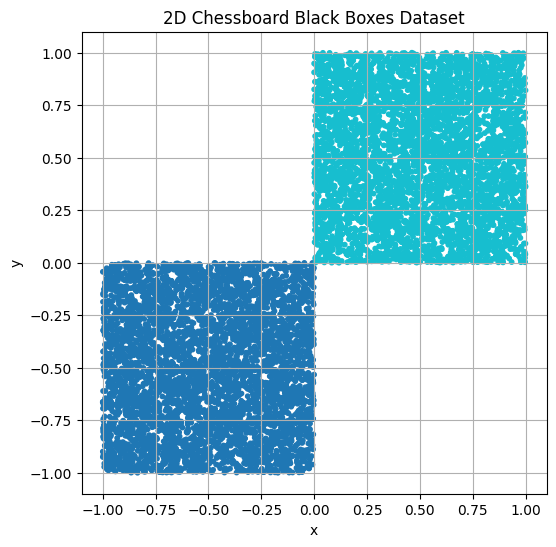

(10000, 2)

In [30]:
input_dim = 2
num_samples = 10000

Z_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

def generate_chessboard_black_boxes(n_samples=5000, noise=0.1, box=2):
    # Create the data grid for the black boxes only
    x = []
    y = []
    labels = []
    color_idx = 0

    for i in range(-box, box):
        for j in range(-box, box):
            if (i + j) % 2 == 0:  # Condition for black boxes
                # Generate samples within the black box
                x_box = np.random.rand(n_samples//(2*(box**2))) + i
                y_box = np.random.rand(n_samples//(2*(box**2))) + j
                
                # Add noise to the points
                # x_box += np.random.normal(0, noise, n_samples//8)
                # y_box += np.random.normal(0, noise, n_samples//8)
                
                x.extend(x_box)
                y.extend(y_box)
                labels.extend([color_idx] * (n_samples//(2*(box**2))))
                color_idx += 1
    
    return np.array(x), np.array(y), np.array(labels)

# Generate chessboard dataset with only black boxes filled
x_black, y_black, labels_black = generate_chessboard_black_boxes(box=1, n_samples=10000)

def plot_test_data(x_black, y_black, labels_black):
    
    # Plotting the dataset
    plt.figure(figsize=(6, 6))
    plt.scatter(x_black, y_black, c=labels_black, cmap='tab10', s=10)
    plt.title("2D Chessboard Black Boxes Dataset")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

plot_test_data(x_black, y_black, labels_black)
X_np = np.concat((x_black.reshape((-1, 1)), y_black.reshape((-1, 1))), axis=1)
X_np.shape

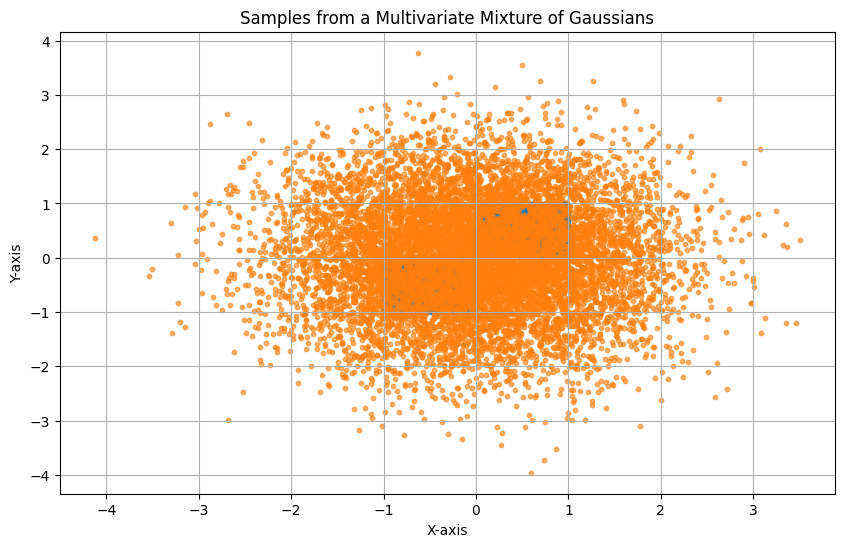

In [31]:
# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=10, alpha=0.6)
plt.scatter(Z_np[:, 0], Z_np[:, 1],  s=10, alpha=0.6)
plt.title('Samples from a Multivariate Mixture of Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [32]:
X = torch.from_numpy(X_np)
Z = torch.from_numpy(Z_np)

# Create an instance of the custom dataset
dataset = CustomDataset(X, Z)

# Create a DataLoader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

model = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model.parameters(), lr=0.01)
save_loss = []
num_epochs = 50
scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

/datastor1/vansh/conda_install/miniconda3/envs/ml/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [34]:
save_loss = train(model, num_epochs, dataloader, save_loss)

Epoch [1/50], Average Loss: 9.6873
Epoch [2/50], Average Loss: 1.3668
Epoch [3/50], Average Loss: 1.1792
Epoch [4/50], Average Loss: 1.0545
Epoch [5/50], Average Loss: 1.0426
Epoch [6/50], Average Loss: 1.0425
Epoch [7/50], Average Loss: 1.0331
Epoch [8/50], Average Loss: 0.9725
Epoch [9/50], Average Loss: 0.9218
Epoch [10/50], Average Loss: 0.8996
Epoch [11/50], Average Loss: 0.8526
Epoch [12/50], Average Loss: 0.8312
Epoch [13/50], Average Loss: 0.8208
Epoch [14/50], Average Loss: 0.8169
Epoch [15/50], Average Loss: 0.8202
Epoch [16/50], Average Loss: 0.8044
Epoch [17/50], Average Loss: 0.8009
Epoch [18/50], Average Loss: 0.7993
Epoch [19/50], Average Loss: 0.8011
Epoch [20/50], Average Loss: 0.7988
Epoch [21/50], Average Loss: 0.8000
Epoch [22/50], Average Loss: 0.7985
Epoch [23/50], Average Loss: 0.8027
Epoch [24/50], Average Loss: 0.7980
Epoch [25/50], Average Loss: 0.7946
Epoch [26/50], Average Loss: 0.7990
Epoch [27/50], Average Loss: 0.7960
Epoch [28/50], Average Loss: 0.7964
E

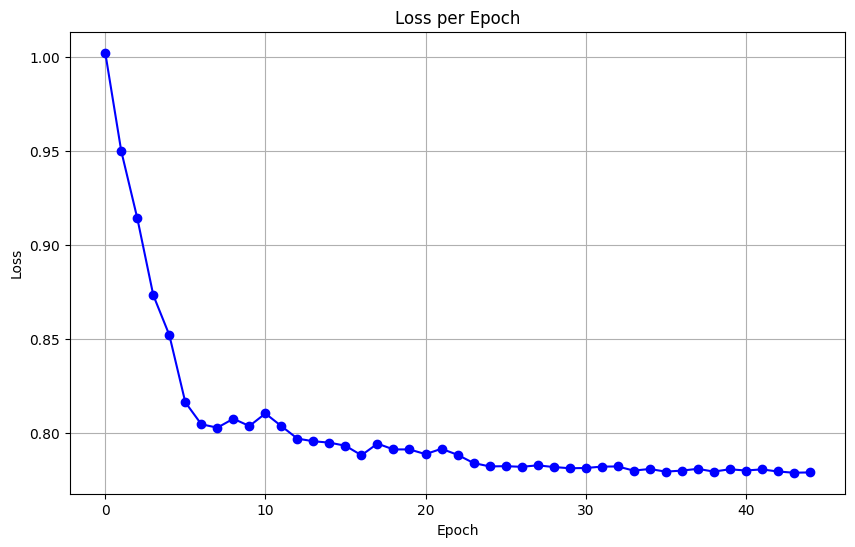

In [16]:
plot_loss(save_loss[5:])

In [17]:
# set_random_seed(2)

models = {}

models[1] = model

In [18]:
from geomloss import SamplesLoss

OT = SamplesLoss("sinkhorn", p=2, blur=0.00001)
# wasserstein_distances = {}
pot_wasserstein_distances = {}
device_name = f'cuda:{1}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print('Using {} device'.format(device))

disc_steps_list = np.arange(1, 21)
wasserstein_distances = {}
gamma = {}


Using cuda:1 device


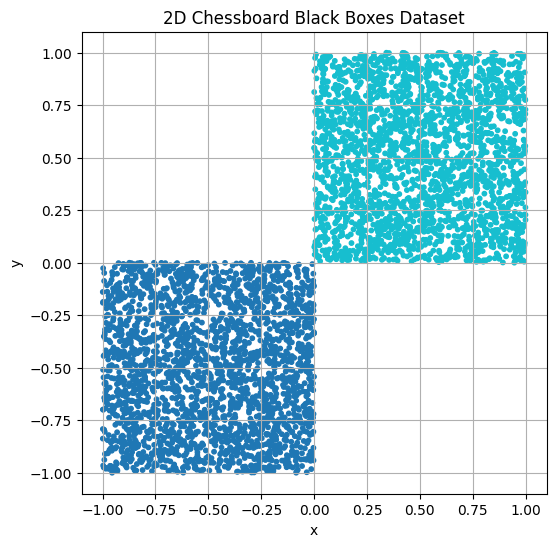

1 2
2001
1000
667
500
400
6 2
333
285
250
222
200
11 2
181
166
153
142
133
16 2
125
117
111
105
100


In [23]:
# num_labels = 8
# for disc_steps_list in disc_steps_list:
#     trajectory, save_drift = sample(model, disc_steps_list, num_samples, 2)

exp_norm_dot_vt = {}
for box in range(1, 2):
    K_1 = 2*(box**2)
    wasserstein_distances[K_1] = {}
    gamma[K_1] = {}

    x_black, y_black, colors = generate_chessboard_black_boxes(box=box)
    X_test = np.concat((x_black.reshape((-1, 1)), y_black.reshape((-1, 1))), axis=1)
    plot_test_data(x_black, y_black, colors)

    trajectory, _ = sample(models[box], T=2000, num_samples=10000, input_dim=2)
    expected_norm_squared_vector = d_model_dt_norm_sq(models[box], trajectory, device)
    exp_norm_dot_vt[K_1] = expected_norm_squared_vector
    # plt.scatter(X_test[:, 0], X_test[:, 1])
    # plt.title("Test dist")
    # plt.show()
    # plt.close()
    for disc_steps in disc_steps_list:
        if (disc_steps-1)%5==0:
            print(disc_steps, K_1)
        trajectory, _ = trajectory, _ = sample(models[box], T=disc_steps, num_samples=500, input_dim=2)
        # plt.scatter(trajectory[-1, :, 0], trajectory[-1, :, 1])
        # plt.title(f"disc_steps: {disc_steps}")
        # plt.show()
        # plt.close()
        gamma[K_1][disc_steps] = gamma_st(expected_norm_squared_vector, disc_steps)
        wasserstein_distances[K_1][disc_steps] = OT(trajectory[-1, :, :].to(dtype=torch.float32), torch.from_numpy(X_test).to(device).to(dtype=torch.float32)).cpu().numpy()
    

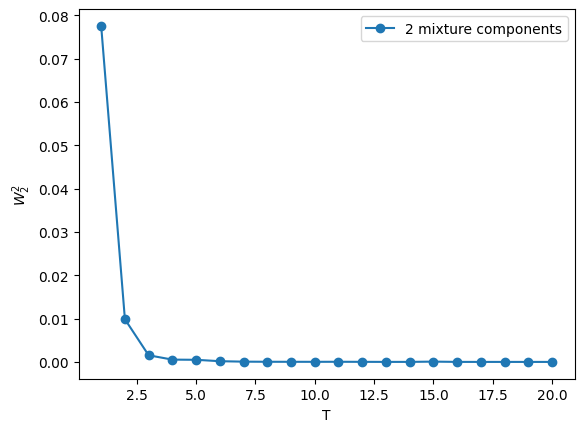

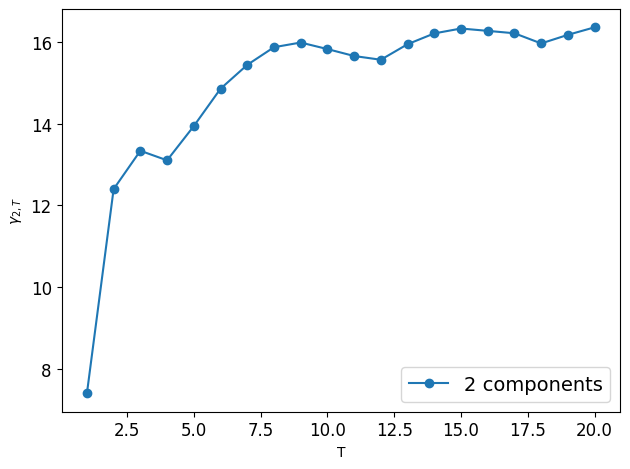

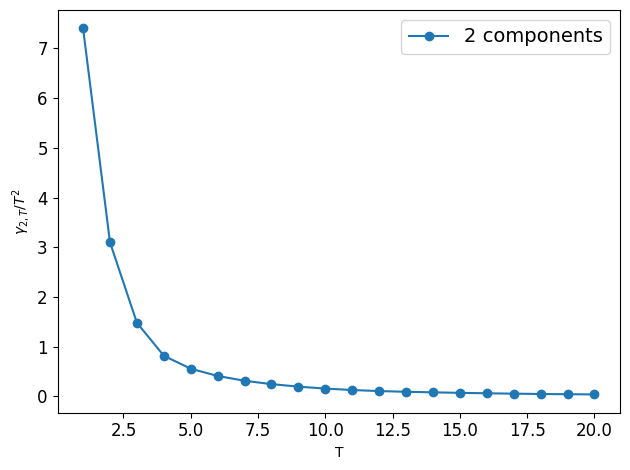

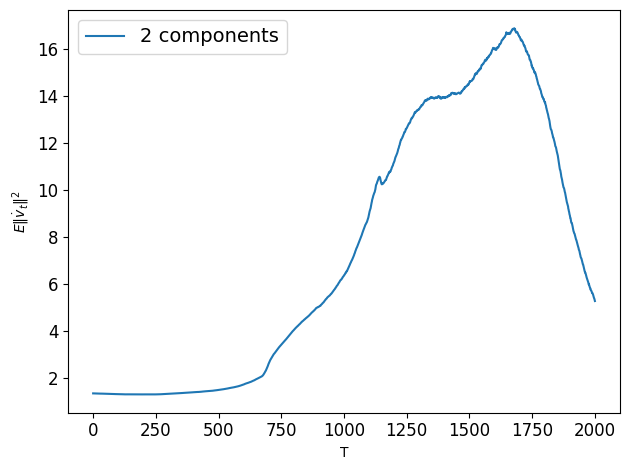

In [26]:
# pot_wasserstein_distances
# dist_3 = np.array(list(wasserstein_distances[3].values()))
# dist_2 = np.array(list(wasserstein_distances[2].values()))
# dist_4 = np.array(list(wasserstein_distances[4].values()))

import json
import os

mins = []
for K_1 in range(2, 3):
    dist = np.array(list(wasserstein_distances[K_1].values()))

    # mins.append(disc_steps_list[np.argmin(dist)])
    # print(disc_steps_list[np.argmin(dist)])
    plt.plot(disc_steps_list, ((dist)**2), marker="o", label=f"{K_1} mixture components")
    plt.legend()
# plt.savefig(os.path.join(path, "log-wasserstein-vs-T.png"))
plt.xlabel("T", fontsize=20)
plt.ylabel(r"$W^2_2$", fontsize=20)
plt.show()
plt.close()

for K_1 in range(2, 3):
    dist = np.array(list(gamma[K_1].values()))

    # mins.append(disc_steps_list[np.argmin(dist)])
    # print(disc_steps_list[np.argmin(dist)])
    plt.plot(disc_steps_list, (dist), marker="o", label=f"{K_1} components")
    plt.legend()
plt.xlabel("T", fontsize=20)
plt.ylabel(r"$\gamma_{2, T}$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12) 
# plt.title('Wasserstein Distance vs Disc Steps (T) [Log-Log]')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

for K_1 in range(2, 3):
    dist = np.array(list(gamma[K_1].values()))

    plt.plot(disc_steps_list, (dist)/np.square(disc_steps_list), marker="o", label=f"{K_1} components")
    plt.legend()
# plt.savefig(os.path.join(path, "gamma-vs-T.png"))
plt.xlabel("T", fontsize=20)
plt.ylabel(r"$\gamma_{2, T}/T^2$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12) 
# plt.title('Wasserstein Distance vs Disc Steps (T) [Log-Log]')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

for K_1 in range(2, 3):
    dist = exp_norm_dot_vt[K_1]

    plt.plot((dist), label=f"{K_1} components")
    plt.legend()
# plt.savefig(os.path.join(path, "gamma-vs-T.png"))
plt.xlabel("T", fontsize=20)
plt.ylabel(r"$E\|\dot v_t\|^2$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12) 
# plt.title('Wasserstein Distance vs Disc Steps (T) [Log-Log]')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

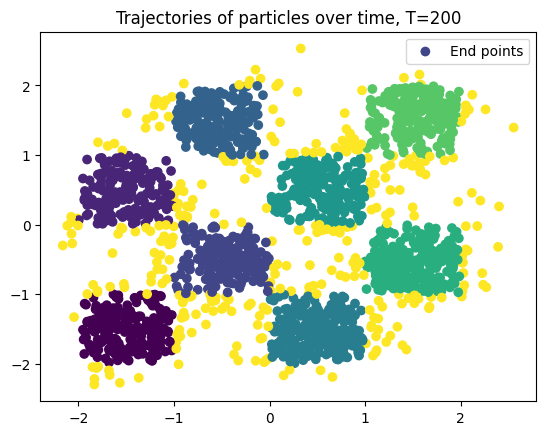

In [41]:
plot_trajectories(trajectory, plot_paths=False, plot_true=False)

In [18]:
X_1, Z_1 = trajectory[T, :, :], trajectory[0, :, :]

dataset_1 = CustomDataset(X_1, Z_1)
dataloader_1 = DataLoader(dataset_1, batch_size=batch_size, shuffle=True)

model_1 = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model_1.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)